In [24]:
import re, ast, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import clear_output

In [25]:
LOG_PATH = Path("../logs/celery/worker.log")   # cambia si tu ruta es distinta
OUT_DIR = Path("analysis/reports"); OUT_DIR.mkdir(parents=True, exist_ok=True)

pat = re.compile(r"Task\s+logistica\.procesar_entrega\[(?P<task_id>[^\]]+)\]\s+succeeded\s+in\s+(?P<secs>[\d\.]+)s:\s+(?P<payload>\{.*\})")

In [37]:
rows=[]
with LOG_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        m = pat.search(line)
        if not m:
            continue
        task_id = m.group("task_id").strip()
        duration = float(m.group("secs"))
        payload_txt = m.group("payload")
        try:
            payload = ast.literal_eval(payload_txt)
        except Exception:
            try: payload = json.loads(payload_txt.replace("'", '"'))
            except Exception: payload = {}
        rows.append({
            "entrega_id": payload.get("entrega_id"),
            "task_id": task_id,
            "status": payload.get("status"),
            "retry": payload.get("retry_count"),
            "duration_s": duration,
        })

clear_output(wait=True)
out = Path(".")
out.mkdir(parents=True, exist_ok=True)
df.to_csv(out / "worker_durations_simple.csv", index=False)


,entrega_id,task_id,status,retry,duration_s
0,54,db431129-f1cd-43fb-869e-985442429b5c,PENDING_SYSTEM_CONFIRMATION,0,1.358902
1,54,73d43c61-7f17-458b-8801-d29ae517a1b4,ENTREGADA,1,0.443931
2,55,21b9ad31-cb3b-420c-baec-455212456b3c,PENDING_SYSTEM_CONFIRMATION,0,2.705675
3,55,7643699f-31cc-44f3-a7e8-3011707a443b,ENTREGADA,1,0.670368
4,56,fa352c21-4197-466f-8f19-e468d9d41e7c,PENDING_SYSTEM_CONFIRMATION,0,2.106614
5,56,21402cf1-ba37-4394-9d8b-b8ac212248d5,ENTREGADA,1,0.906506
6,57,bfda1ebe-7aba-4402-b736-c5a88b402e6f,ENTREGADA,0,0.114172
7,58,17d2e74a-6856-4c35-a016-5ca1c399c055,ENTREGADA,0,1.474696
8,59,7511e1a9-0324-4c49-815a-88b8b29affe3,PENDING_SYSTEM_CONFIRMATION,0,1.453324
9,59,1cb18d2f-147c-46ee-bf4d-9d65a694edac,ENTREGADA,1,1.665463


Resumen duración (s):
count    70.000000
mean      1.337762
std       0.635210
min       0.048588
50%       1.446184
90%       2.161132
95%       2.406937
99%       2.716146
max       2.739453
Name: duration_s, dtype: float64


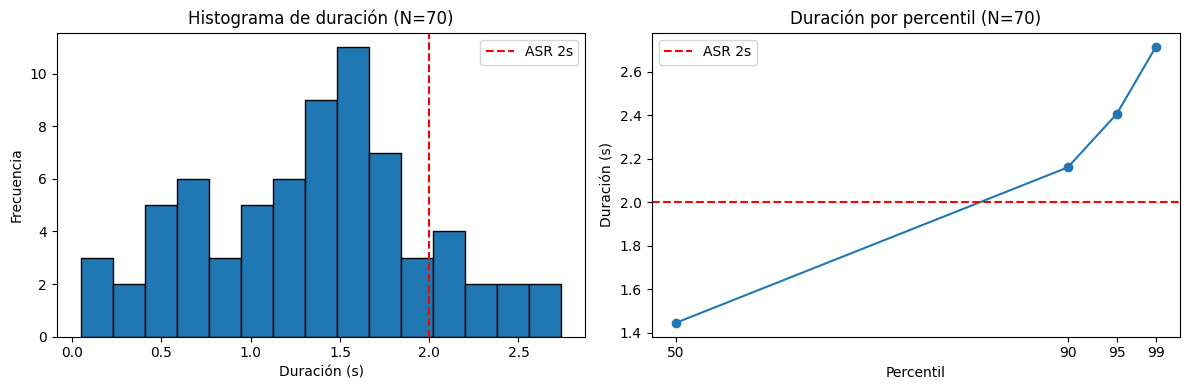

In [38]:
df = pd.DataFrame(rows, columns=["entrega_id","task_id","status","retry","duration_s"])\
    .sort_values(["entrega_id","retry"])\
    .reset_index(drop=True)
display(df.head(10))

print("Resumen duración (s):")
print(df["duration_s"].describe(percentiles=[.5,.9,.95,.99]))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
n = len(df)

# Histograma
axes[0].hist(df["duration_s"], bins=15, edgecolor="black")
axes[0].axvline(2, color="red", linestyle="--", label="ASR 2s")
axes[0].set_title(f"Histograma de duración (N={n})")
axes[0].set_xlabel("Duración (s)")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# Percentiles
percentiles = [50, 90, 95, 99]
values = [df["duration_s"].quantile(p/100) for p in percentiles]
axes[1].plot(percentiles, values, marker="o")
axes[1].axhline(2, color="red", linestyle="--", label="ASR 2s")
axes[1].set_title(f"Duración por percentil (N={n})")
axes[1].set_xlabel("Percentil")
axes[1].set_ylabel("Duración (s)")
axes[1].set_xticks(percentiles)
axes[1].legend()

plt.tight_layout()
plt.show()

,entrega_id,task_id,status,retry,duration_s
0,54,73d43c61-7f17-458b-8801-d29ae517a1b4,ENTREGADA,1,0.443931
1,55,7643699f-31cc-44f3-a7e8-3011707a443b,ENTREGADA,1,0.670368
2,56,21402cf1-ba37-4394-9d8b-b8ac212248d5,ENTREGADA,1,0.906506
3,57,bfda1ebe-7aba-4402-b736-c5a88b402e6f,ENTREGADA,0,0.114172
4,58,17d2e74a-6856-4c35-a016-5ca1c399c055,ENTREGADA,0,1.474696
5,59,1cb18d2f-147c-46ee-bf4d-9d65a694edac,ENTREGADA,1,1.665463
6,60,862af317-5086-4658-951e-090a8fb9faad,ENTREGADA,0,1.513359
7,61,8f0d5817-4a36-438a-93f3-ac54c5431fb6,ENTREGADA,1,1.123148
8,62,c3a12e71-e4f5-45d4-961d-dc40ec55e013,ENTREGADA,0,0.378155
9,63,17fab81a-53b0-471b-9d7f-c60df755b291,ENTREGADA,0,0.974452


Resumen duración (s):
count    48.000000
mean      1.105037
std       0.545167
min       0.048588
50%       1.128910
90%       1.702687
95%       1.847039
99%       1.971518
max       1.972300
Name: duration_s, dtype: float64


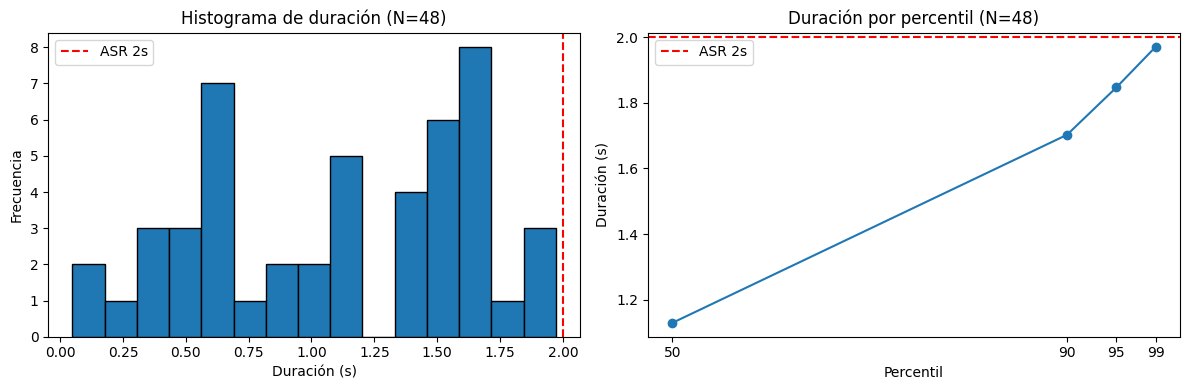

In [39]:
df = pd.DataFrame(rows, columns=["entrega_id","task_id","status","retry","duration_s"])\
    .query("status == 'ENTREGADA'")\
    .sort_values(["entrega_id","retry"])\
    .reset_index(drop=True)
display(df.head(10))

print("Resumen duración (s):")
print(df["duration_s"].describe(percentiles=[.5,.9,.95,.99]))


fig, axes = plt.subplots(1, 2, figsize=(12,4))
n = len(df)

# Histograma
axes[0].hist(df["duration_s"], bins=15, edgecolor="black")
axes[0].axvline(2, color="red", linestyle="--", label="ASR 2s")
axes[0].set_title(f"Histograma de duración (N={n})")
axes[0].set_xlabel("Duración (s)")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# Percentiles
percentiles = [50, 90, 95, 99]
values = [df["duration_s"].quantile(p/100) for p in percentiles]
axes[1].plot(percentiles, values, marker="o")
axes[1].axhline(2, color="red", linestyle="--", label="ASR 2s")
axes[1].set_title(f"Duración por percentil (N={n})")
axes[1].set_xlabel("Percentil")
axes[1].set_ylabel("Duración (s)")
axes[1].set_xticks(percentiles)
axes[1].legend()

plt.tight_layout()
plt.show()

,entrega_id,task_id,status,retry,duration_s
0,54,db431129-f1cd-43fb-869e-985442429b5c,PENDING_SYSTEM_CONFIRMATION,0,1.358902
1,55,21b9ad31-cb3b-420c-baec-455212456b3c,PENDING_SYSTEM_CONFIRMATION,0,2.705675
2,56,fa352c21-4197-466f-8f19-e468d9d41e7c,PENDING_SYSTEM_CONFIRMATION,0,2.106614
3,59,7511e1a9-0324-4c49-815a-88b8b29affe3,PENDING_SYSTEM_CONFIRMATION,0,1.453324
4,61,b7e56bc8-1ea6-41b0-ac2a-609ed0c0660b,PENDING_SYSTEM_CONFIRMATION,0,1.699136
5,64,11359a8c-9cda-46fc-8709-c7a0e7cc4839,PENDING_SYSTEM_CONFIRMATION,0,2.183225
6,66,7ad3e2a7-36ea-43e4-b909-c03a65cc9fa0,PENDING_SYSTEM_CONFIRMATION,0,1.470310
7,68,18b1a979-8143-4950-a86f-e76414f8a3ca,PENDING_SYSTEM_CONFIRMATION,0,1.644811
8,69,d67db673-a20f-41ee-b7ba-663b97eafe3a,PENDING_SYSTEM_CONFIRMATION,0,2.081632
9,70,59530eb4-e7e4-4ff2-8375-39045c2d6da7,PENDING_SYSTEM_CONFIRMATION,0,2.458251


Resumen duración (s):
count    22.000000
mean      1.845526
std       0.516414
min       1.093215
50%       1.671974
90%       2.457645
95%       2.693304
99%       2.732360
max       2.739453
Name: duration_s, dtype: float64


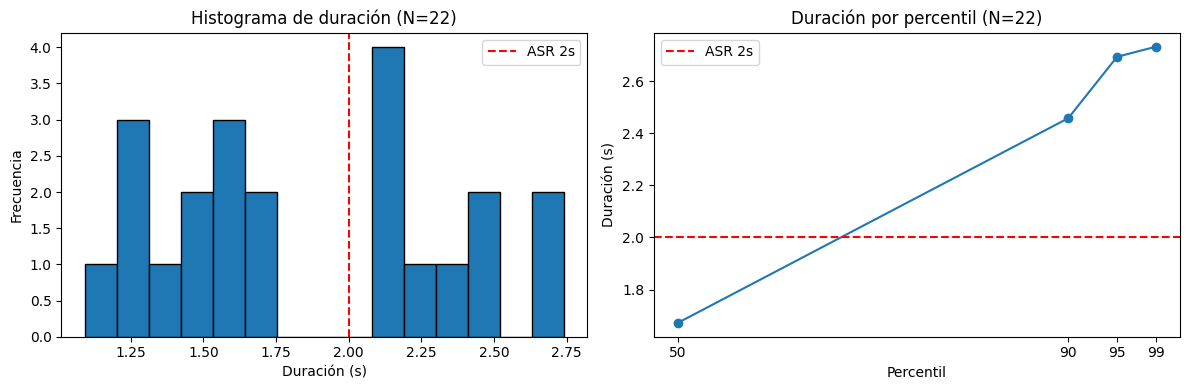

In [35]:
df = pd.DataFrame(rows, columns=["entrega_id","task_id","status","retry","duration_s"])\
    .query("status == 'PENDING_SYSTEM_CONFIRMATION'")\
    .sort_values(["entrega_id","retry"])\
    .reset_index(drop=True)
display(df.head(10))

print("Resumen duración (s):")
print(df["duration_s"].describe(percentiles=[.5,.9,.95,.99]))


fig, axes = plt.subplots(1, 2, figsize=(12,4))
n = len(df)

# Histograma
axes[0].hist(df["duration_s"], bins=15, edgecolor="black")
axes[0].axvline(2, color="red", linestyle="--", label="ASR 2s")
axes[0].set_title(f"Histograma de duración (N={n})")
axes[0].set_xlabel("Duración (s)")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# Percentiles
percentiles = [50, 90, 95, 99]
values = [df["duration_s"].quantile(p/100) for p in percentiles]
axes[1].plot(percentiles, values, marker="o")
axes[1].axhline(2, color="red", linestyle="--", label="ASR 2s")
axes[1].set_title(f"Duración por percentil (N={n})")
axes[1].set_xlabel("Percentil")
axes[1].set_ylabel("Duración (s)")
axes[1].set_xticks(percentiles)
axes[1].legend()

plt.tight_layout()
plt.show()